In [1]:
# import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import numpy as np
import xarray as xr
import math as m
from datetime import datetime
from datetime import timedelta
from glob import glob
from parcels import (grid, Field, FieldSet, SummedField, VectorField, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)



path_dataSMOC = '/data/oceanparcels/input_data/CMEMS/GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/'



In [2]:
#### FIELDSET SMOC #####

SMOCfiles = path_dataSMOC+'SMOC_201803*.nc'
filenames_SMOC = {'U': SMOCfiles,
                   'V': SMOCfiles}
variables_SMOC = {'U' : 'uo',
             'V' : 'vo'}
dimensions_SMOC = {'U': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude',
                   'depth': 'depth'},
              'V': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude',
                   'depth': 'depth'}}
indices_SMOC = {'lon' : range(1380, 1620),
           'lat' : range(1620,1740)}
#mesh = fieldFiles[0]
filenames_SMOC = {'U': SMOCfiles,
                   'V': SMOCfiles}
variables_tides = {'U' : 'utide',
             'V' : 'vtide'}
dimensions_tides = {'U': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude',
                   'depth': 'depth'},
              'V': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude',
                   'depth': 'depth'}}
indices_SMOC = {'lon' : range(1380, 1620),
           'lat' : range(1620,1740)}
fieldset_ns = FieldSet.from_netcdf(filenames_SMOC, 
                            variables_SMOC, 
                            dimensions_SMOC,
                            indices_SMOC,
                            allow_time_extrapolation = True,
                           )
fieldset_tides = FieldSet.from_netcdf(filenames_SMOC, 
                    variables_tides, 
                    dimensions_tides,
                    indices_SMOC,
                    allow_time_extrapolation = True,
                   )
fieldset= FieldSet(U=fieldset_ns.U+fieldset_tides.U, V=fieldset_ns.V+fieldset_tides.V)





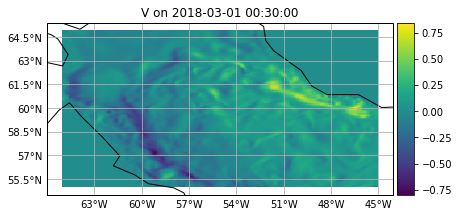

V


In [6]:
def aging(particle, fieldset,time):
    particle.Age+=particle.dt
    if particle.Age>3600*24*15:
        particle.delete()


def deleteparticle(particle,fieldset,time):
    """ This function deletes particles as they exit the domain and prints a message about their attributes at that moment
    """
    particle.delete()
    
    
def SampleVel(particle, fieldset, time):
         particle.u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
         particle.v = fieldset.V[time, particle.depth, particle.lat, particle.lon]
#          particle.u = fieldset.U[0].eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)\
#                     + fieldset.U[1].eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)
#          particle.v = fieldset.V[0].eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)\
#                     + fieldset.V[1].eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)

In [7]:
lon = np.linspace(-65,-45,100)
lat=np.linspace(55,65,100)
LON, LAT = np.meshgrid(lon,lat)
times = np.full(np.shape(LON),np.datetime64('2018-03-02'))
depths = np.full_like(LON, 0.494025)
 

In [8]:

##### PARTICLE SET ####
class BuoyParticle(JITParticle):
    Age=Variable('Age',initial=0)
    u = Variable('u', initial=0)
    v = Variable('v', initial=0)
    
lon = np.linspace(-65,-45,10)
lat=np.linspace(55,65,10)
# LON, LAT = np.meshgrid(lon,lat)
# times = np.full(np.shape(LON),np.datetime64('2018-03-02'))
# depths = np.full_like(LON, 0.494025)


##SMOC
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=BuoyParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=LON, # a vector of release longitudes 
                             lat=LAT,    # a vector of release latitudes
                              time=times,
                            depth=depths)

age_kernel = pset.Kernel(aging)
sample_kernel = pset.Kernel(SampleVel)    # Casting the SampleVel function to a kernel.


TypeError: ccode_eval() missing 3 required positional arguments: 'z', 'y', and 'x'

In [6]:
#Execute  the kernel and write to file
output_file = pset.ParticleFile(name="diff_model_WT.nc", outputdt=3600) # the file name and the time step of the outputs
pset.execute(AdvectionRK4+age_kernel+sample_kernel,                 # the kernel (which defines how particles move)
             runtime=3600*24*10,    # the total length of the run
             dt=600,      # the timestep of the kernel
             recovery= {ErrorCode.ErrorOutOfBounds:deleteparticle}, #delete particle when it gets out of the domain
             output_file=output_file)
output_file.close()

INFO: Compiled BuoyParticleAdvectionRK4agingSampleVel ==> /tmp/parcels-5388/b2772e7161d7e1877ea652b6aaa861ed_0.so
INFO: Temporary output files are stored in out-REABXGWP.
INFO: You can use "parcels_convert_npydir_to_netcdf out-REABXGWP" to convert these to a NetCDF file during the run.
100% |########################################################################|


<xarray.Dataset>
Dimensions:     (obs: 241, traj: 1)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 60.0 60.004623 ... 59.579044 59.573402
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    Age         (traj, obs) float32 ...
    u           (traj, obs) float32 0.0 -0.048307553 ... 0.05861534 0.059863575
    v           (traj, obs) float32 0.0 0.13084988 ... -0.16858481 -0.1759905
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev126+g6dd05b7
    parcels_mesh:           spherical

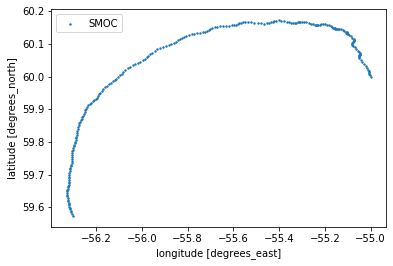

In [15]:
plt.figure()
output = xr.open_dataset('diff_model_WT.nc')
output.plot.scatter(y='lat',x='lon',label='SMOC',s=2)


plt.legend()

#Convert to meters/s
output['u']= output.u*1852*60*np.cos(output.lat*np.pi/180)
output['v'] = output.v*1852*60





Waarom doet het summed veld het niet, en hoe kan ik fields van elkaar aftrekken??

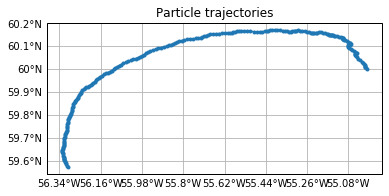

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

In [17]:
D_11 = -output.u[:,15:]*(output.lon[:,15:]-output.lon[:,:-15])/360*40075e3*np.cos(output.lat[:,15:])
D_12 = -output.u[:,15:]*(output.lat[:,15:]-output.lat[:,:-15])/360*40075e3
D_21 = -output.v[:,15:]*(output.lon[:,15:]-output.lon[:,:-15])/360*40075e3*np.cos(output.lat[:,15:])
D_22 = -output.v[:,15:]*(output.lat[:,15:]-output.lat[:,:-15])/360*40075e3
D_11 = np.ravel(D_11)
D_12 = np.ravel(D_12)
D_21 = np.ravel(D_21)
D_22 = np.ravel(D_22)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:154: ComplexWarning: Casting complex values to real discards the imaginary part


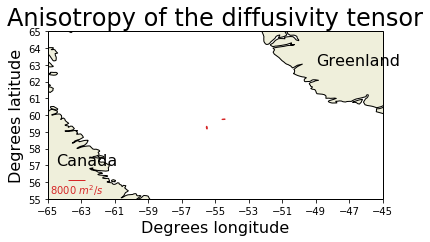

In [18]:
from binned_statistic2 import binned_statistic_2d_new
Nbin = 20
D_11_bin,  xedges, yedges,binnumber_davis = binned_statistic_2d_new(np.ravel(output.lon[:,15:]),np.ravel(output.lat[:,15:]),D_11.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin)
D_12_bin,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(np.ravel(output.lon[:,15:]),np.ravel(output.lat[:,15:]), D_12.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin, expand_binnumbers=True)
D_21_bin,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(np.ravel(output.lon[:,15:]),np.ravel(output.lat[:,15:]), D_21.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin, expand_binnumbers=True)
D_22_bin,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(np.ravel(output.lon[:,15:]),np.ravel(output.lat[:,15:]), D_22.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin, expand_binnumbers=True)
counts,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(np.ravel(output.lon[:,15:]),np.ravel(output.lat[:,15:]),D_11.astype('float'), statistic='count',bins=Nbin, range=([-65,-45],[55,65]), expand_binnumbers=True)

from scipy import linalg

D_11_bin=np.swapaxes(D_11_bin, 0, 1)
D_12_bin=np.swapaxes(D_12_bin, 0, 1)
D_21_bin=np.swapaxes(D_21_bin, 0, 1)
D_22_bin=np.swapaxes(D_22_bin, 0, 1)
counts=np.swapaxes(counts, 0, 1)

#Define grid
lon=np.linspace(-64.5, -45.5, Nbin)
lat = np.linspace(55.25, 64.25, Nbin)
lon, lat = np.meshgrid(lon, lat)

x = np.linspace(-64.5, -45.5,Nbin)
y = np.linspace(55.25, 64.75,Nbin)
X, Y = np.meshgrid(x, y)

    #%% Add the diffusivity components to 1 xarray dataset
k_matrix =xr.Dataset({'k11':(['x','y'],D_11_bin),
                      'k12':(['x','y'],D_12_bin),
                      'k21':(['x','y'],D_21_bin),
                      'k22':(['x','y'],D_22_bin)},                     
                  coords={
                "lon": (["x","y"],lon),
                  "lat": (["x","y"],lat)},)

#Symmetric part:
k_S =xr.Dataset({'k11':(['lat','lon'],D_11_bin),
                      'k12':(['lat','lon'],(D_12_bin+D_21_bin)/2),
                      'k21':(['lat','lon'],(D_21_bin+D_12_bin)/2),
                      'k22':(['lat','lon'],D_22_bin)},                     
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},)

#Same for the number of counts per grid cell
counts_xr =xr.Dataset({'counts':(['x','y'],counts)},                     
                  coords={
                "lon": (["x","y"],lon),
                  "lat": (["x","y"],lat)},)
# Filter out grid cells with less then 50 data points
for i in range(Nbin):
    for j in range(Nbin):
        if counts_xr.counts[i,j]<20:
            k_S.k11[i,j] = np.nan
            k_S.k12[i,j] = np.nan
            k_S.k21[i,j] = np.nan
            k_S.k22[i,j] = np.nan
#%%




#%%
#Create arrays for eigen values and eigenvectors:
eig_val = np.zeros((len(lat),len(lon),2))
eig_vec = np.zeros((len(lat),len(lon),2,2))

#Calculate the eigenvalues and eigenvectors for every bin:
for i in range(Nbin):
    for j in range(Nbin):
        try:
            eig_val[i,j,:], eig_vec[i,j,:,:] = linalg.eig(k_S.isel(lat=i,lon=j).\
                to_array().values.reshape(2,2),check_finite=True)
        except (ValueError): #If there are nan values in the diffusivity: fill eigenvalue and eigenvectors with nans
            eig_val[i,j,:]=[np.nan, np.nan]
            eig_vec[i,j,:,:]=([np.nan, np.nan],[np.nan, np.nan])
            continue


#Make an xarray dataset of the eigenvalues and eigenvectors:
eig_val =xr.Dataset({'labda':(['lat','lon','i'],eig_val)},
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},)
eig_vec =xr.Dataset({'mu':(['lat','lon','i','j'],eig_vec)},
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},
                  attrs={
                      "title": 'Eigen vectors per grid cell'})

from scipy import linalg

D_11_bin=np.swapaxes(D_11_bin, 0, 1)
D_12_bin=np.swapaxes(D_12_bin, 0, 1)
D_21_bin=np.swapaxes(D_21_bin, 0, 1)
D_22_bin=np.swapaxes(D_22_bin, 0, 1)
counts=np.swapaxes(counts, 0, 1)

#Define grid
lon=np.linspace(-64.5, -45.5, Nbin)
lat = np.linspace(55.25, 64.25, Nbin)
lon, lat = np.meshgrid(lon, lat)

x = np.linspace(-64.5, -45.5,Nbin)
y = np.linspace(55.25, 64.75,Nbin)
X, Y = np.meshgrid(x, y)

    #%% Add the diffusivity components to 1 xarray dataset
k_matrix =xr.Dataset({'k11':(['x','y'],D_11_bin),
                      'k12':(['x','y'],D_12_bin),
                      'k21':(['x','y'],D_21_bin),
                      'k22':(['x','y'],D_22_bin)},                     
                  coords={
                "lon": (["x","y"],lon),
                  "lat": (["x","y"],lat)},)

#Symmetric part:
k_S =xr.Dataset({'k11':(['lat','lon'],D_11_bin),
                      'k12':(['lat','lon'],(D_12_bin+D_21_bin)/2),
                      'k21':(['lat','lon'],(D_21_bin+D_12_bin)/2),
                      'k22':(['lat','lon'],D_22_bin)},                     
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},)

#Same for the number of counts per grid cell
counts_xr =xr.Dataset({'counts':(['x','y'],counts)},                     
                  coords={
                "lon": (["x","y"],lon),
                  "lat": (["x","y"],lat)},)
# Filter out grid cells with less then 50 data points
for i in range(Nbin):
    for j in range(Nbin):
        if counts_xr.counts[i,j]<20:
            k_S.k11[i,j] = np.nan
            k_S.k12[i,j] = np.nan
            k_S.k21[i,j] = np.nan
            k_S.k22[i,j] = np.nan
#%%




#%%
#Create arrays for eigen values and eigenvectors:
eig_val = np.zeros((len(lat),len(lon),2))
eig_vec = np.zeros((len(lat),len(lon),2,2))

#Calculate the eigenvalues and eigenvectors for every bin:
for i in range(Nbin):
    for j in range(Nbin):
        try:
            eig_val[i,j,:], eig_vec[i,j,:,:] = linalg.eig(k_S.isel(lat=i,lon=j).\
                to_array().values.reshape(2,2),check_finite=True)
        except (ValueError): #If there are nan values in the diffusivity: fill eigenvalue and eigenvectors with nans
            eig_val[i,j,:]=[np.nan, np.nan]
            eig_vec[i,j,:,:]=([np.nan, np.nan],[np.nan, np.nan])
            continue


#Make an xarray dataset of the eigenvalues and eigenvectors:
eig_val =xr.Dataset({'labda':(['lat','lon','i'],eig_val)},
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},)
eig_vec =xr.Dataset({'mu':(['lat','lon','i','j'],eig_vec)},
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},
                  attrs={
                      "title": 'Eigen vectors per grid cell'})

from plotting_functions import plot_ellipse
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.collections import EllipseCollection

plot_ellipse(eig_val, eig_vec, Nbin)


